In [1]:
#import re
import multiprocessing
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# sklearn
#from sklearn.model_selection import train_test_split

#nlp
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec, CoherenceModel

#import pyLDAvis
#import pyLDAvis.gensim_models  # don't skip this

import nltk; nltk.download('stopwords')
import spacy
from spacy.matcher import Matcher
nlp = spacy.load("es_core_news_sm")
print(spacy.__version__)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rickiwasho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.1.3


Clasificar noticias en función de la taxonomía siguiente:

In [2]:
topics = [
    'mundo', 'economía', 'política y conflictos', 'ciencia y tecnología',
    'catástrofes y accidentes', 'cultura y arte', 'deporte', 'ecología y planeta',
    'crimen, delitos y justicia', 'salud'
]

In [3]:
# import dataset 
dataset = pd.read_csv("data/chile_2020-09.csv")[:100]
print(len(dataset))
display(dataset.head(3))

100


,id,country,media_outlet,url,title,text,date,year,id_journalist
0,49234,chile,horas24,https://www.24horas.cl/coronavirus/tia-pikachu...,"""Tía Pikachu"" por parte empadronado: ""Estoy co...","Ha sufrido los embates del carro lanza aguas,...",2020-09-01,2020.0,NaN
1,49252,chile,horas24,https://www.24horas.cl/nacional/tia-pikachu-po...,"""Tía Pikachu"" por parte empadronado: ""Estoy co...",NaN,2020-09-01,2020.0,NaN
2,49277,chile,horas24,https://www.24horas.cl/nacional/los-toscanini-...,Los Toscanini: Cae banda que abastecía a crimi...,NaN,2020-09-01,2020.0,NaN


In [4]:
content = dataset["title"] + '. ' + dataset["text"]
content.replace(" ",np.nan,inplace=True)
content.dropna(inplace=True)
#terms = content['terms']
dataset = pd.DataFrame({'content':content, 'terms': ""})
display(dataset.head(10))

,content,terms
0,"""Tía Pikachu"" por parte empadronado: ""Estoy co...",
3,RM alcanza sus mejores índices de calidad de a...,
6,Paro de camioneros: Supermercados preocupados ...,
7,Sernac recibió más de 400 reclamos durante la ...,
8,Denuncian desabastecimiento en el sur del país...,
9,PDI encuentra a hombre que familia reportó des...,
10,"Bellolio: ""No hay ninguna razón para que prosp...",
13,"Ministro Pérez pide ""actuar con responsabilida...",
16,Alcaldes piden que transporte sea gratuito el ...,
17,Paro de camiones: DC da ultimátum para que min...,


Extraer contexto: conceptos claves

In [5]:
matcher = Matcher(nlp.vocab)

# Pattern 1: NOUN de NOUN
pattern_1 = [{"POS": "NOUN"},{"LOWER": "de"}, {"POS": "NOUN"}]
matcher.add("NOUN-de-NOUN", [pattern_1])

# Pattern 2: NOUN ADJ
pattern_2 = [{"POS": "NOUN"}, {"POS": "ADJ"}]
matcher.add("NOUN-ADJ", [pattern_2])

In [6]:
for i in range(len(dataset)):
    doc = nlp(dataset.iloc[i]['content'])
    matches = matcher(doc)
    categories = ""
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]  # Get string representation
        span = doc[start:end]  # The matched span
        categories = categories + span.text + "; "
    
    dataset['terms'][i] = categories
    
display(dataset.head(50))

,content,terms
0,"""Tía Pikachu"" por parte empadronado: ""Estoy co...",parte empadronado; par de oportunidades; estal...
3,RM alcanza sus mejores índices de calidad de a...,jornada de CyberDay; jornada de CyberDay; falt...
6,Paro de camioneros: Supermercados preocupados ...,acusación constitucional; Paro de camiones; pr...
7,Sernac recibió más de 400 reclamos durante la ...,ultimátum de acusación; acusación constitucion...
8,Denuncian desabastecimiento en el sur del país...,serie de instancias; participación ciudadana; ...
9,PDI encuentra a hombre que familia reportó des...,Paro de camiones; paro de camioneros; acusació...
10,"Bellolio: ""No hay ninguna razón para que prosp...",paro de camiones; aumento de precios; precios ...
13,"Ministro Pérez pide ""actuar con responsabilida...",querella criminal; video de camioneros; camion...
16,Alcaldes piden que transporte sea gratuito el ...,venta de licencias; redes sociales; venta de l...
17,Paro de camiones: DC da ultimátum para que min...,cambio de hora; cambio de hora; cambio de hora...


In [7]:
from collections import Counter
dataset["most_common"] = ""
for i in range(len(dataset)):
    split_it = dataset.iloc[i]['terms'].split("; ")
    counter = Counter(split_it)
    dataset['most_common'][i]  = counter.most_common()[0][0]

display(dataset.head(50))

,content,terms,most_common
0,"""Tía Pikachu"" por parte empadronado: ""Estoy co...",parte empadronado; par de oportunidades; estal...,parte empadronado
3,RM alcanza sus mejores índices de calidad de a...,jornada de CyberDay; jornada de CyberDay; falt...,ultimátum de acusación
6,Paro de camioneros: Supermercados preocupados ...,acusación constitucional; Paro de camiones; pr...,mujeres semidesnudas
7,Sernac recibió más de 400 reclamos durante la ...,ultimátum de acusación; acusación constitucion...,mujeres semidesnudas
8,Denuncian desabastecimiento en el sur del país...,serie de instancias; participación ciudadana; ...,venta de licencias
9,PDI encuentra a hombre que familia reportó des...,Paro de camiones; paro de camioneros; acusació...,cambio de hora
10,"Bellolio: ""No hay ninguna razón para que prosp...",paro de camiones; aumento de precios; precios ...,zona norte
13,"Ministro Pérez pide ""actuar con responsabilida...",querella criminal; video de camioneros; camion...,políticas públicas
16,Alcaldes piden que transporte sea gratuito el ...,venta de licencias; redes sociales; venta de l...,sismo principal
17,Paro de camiones: DC da ultimátum para que min...,cambio de hora; cambio de hora; cambio de hora...,entrevista radial


In [8]:
dataset['most_common'].value_counts()

                            20
mujeres semidesnudas         3
paro de camioneros           2
acusación constitucional     2
tomas de terrenos            1
                            ..
causa de muerte              1
franja televisiva            1
robos de celulares           1
dueños de camiones           1
cantidad de horas            1
Name: most_common, Length: 67, dtype: int64

In [9]:
dataset["category"] = ""
dataset

,content,terms,most_common,category
0,"""Tía Pikachu"" por parte empadronado: ""Estoy co...",parte empadronado; par de oportunidades; estal...,parte empadronado,
3,RM alcanza sus mejores índices de calidad de a...,jornada de CyberDay; jornada de CyberDay; falt...,ultimátum de acusación,
6,Paro de camioneros: Supermercados preocupados ...,acusación constitucional; Paro de camiones; pr...,mujeres semidesnudas,
7,Sernac recibió más de 400 reclamos durante la ...,ultimátum de acusación; acusación constitucion...,mujeres semidesnudas,
8,Denuncian desabastecimiento en el sur del país...,serie de instancias; participación ciudadana; ...,venta de licencias,
...,...,...,...,...
95,"Rodolfo Carter: ""Ser comunista hoy es ser mili...",,,
96,Municipio afirma que baja de ventas llevó a ce...,,,
97,Corte declara admisible recurso de protección ...,,,
98,"""Matamos a cuanto hueón pillamos"": audio inédi...",,,


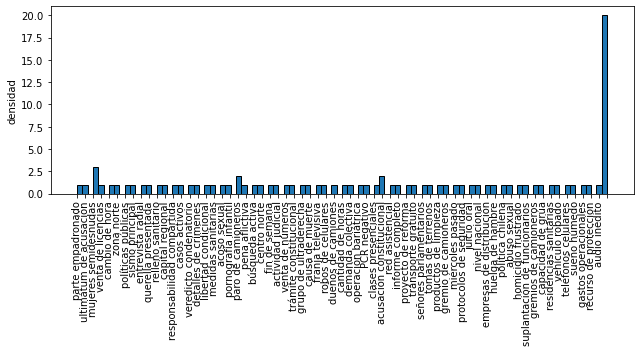

In [10]:
fig, ax = plt.subplots(1, figsize=(9,5), tight_layout=True)
ax.hist(dataset['most_common'],edgecolor = 'black',bins=100)
plt.xticks(rotation='vertical')
plt.ylabel("densidad")
plt.show()

### Definición del modelo word2vec

In [ ]:
model = Word2Vec(min_count=1, #10
                 window=4,
                 sample=6e-5,
                 alpha=0.03,
                 min_alpha=0.0007,
                 negative=20,
                 workers=multiprocessing.cpu_count())

In [ ]:
model.build_vocab(dataset['most_common'])

In [ ]:
train_texts, dev_texts, train_labels, dev_labels = train_test_split(df["text"], 
                                                                    df["title"], 
                                                                    test_size=0.1, 
                                                                    shuffle=True, 
                                                                    random_state=
print("Train:", len(train_texts))
print("Dev:", len(dev_texts))
print("Test:", len(test_texts))

In [ ]:
text = df['text'][0]
display(text)

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')

# Convert to list
data = text.split(" ")

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]



def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data_words = list(sent_to_words(data))

print(data_words)

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[16]]])

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
print(data_lemmatized)

In [ ]:
id2word = corpora.Dictionary(data_lemmatized)
id2word[0]
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]


print(corpus)

In [ ]:
# View
[[(id2word[id], freq) for id, freq in cp] for cp in corpus]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

In [ ]:
doc = nlp(text)
for token in doc:
    print(token.text, token.is_stop, token.lemma_)

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = text.split(" ")
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]
data_words = list(sent_to_words(data))
print(data_words)

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = text.split(" ")
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]
data_words = list(sent_to_words(data))
print(data_words)

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = text.split(" ")
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]
data_words = list(sent_to_words(data))
print(data_words)